# Recipe Review Sentiment Analysis Part 3: A Deep Learning Model 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chillyssa/NLP-with-Deep-Learning-Project/blob/main/project_part3.ipynb)

In my previous notebook [Recipe Review Sentiment Analysis Part 2: A Baseline Model 2.1](https://colab.research.google.com/github/chillyssa/NLP-with-Deep-Learning-Project/blob/main/project_part2-1.ipynb) I continued my NLP sentiment analysis experiment with [recipe review data](https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions) from Food.com's online recipe generator. The original data set comes from Kaggle and was originally gathered for the below cited research. 

Generating Personalized Recipes from Historical User Preferences
Bodhisattwa Prasad Majumder*, Shuyang Li*, Jianmo Ni, Julian McAuley
EMNLP, 2019
https://www.aclweb.org/anthology/D19-1613/

## Reviewing the Baseline Model 

For my baseline model I used a sklearn's [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) which yielded a decent score that performed with 81.7% accuracy on my test data set.

## Using a Deep Learning Model 
This last part of my experiement is going to utilize a pretrained deep learning model from [Hugging Face's transformers](https://huggingface.co/models?library=transformers). Transformers are a type of artificial neural network that can process a whole piece of input or language at once rather than word by word. These models train faster and also work well with large data sets! Since our recipe data is larger, I am hopeful that we may see some success in a better accuracy score. 

## Loading Data and Initializing Environment 

In [1]:
# mount google drive to import data files - only have to run this once. 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# initializing wandb for model optimization and metrics 
# !pip install wandb
import wandb
wandb.login()

wandb.init(project="recipe_review_analysis")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [6]:
# Install transformers and datasets - only run when runtime is first spun up 
# !pip install transformers datasets

# importing modules/packages to be utilized 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification,  TrainingArguments, Trainer
from datasets import Dataset, load_metric
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score



# importing data set with pandas
pd.set_option('display.max_colwidth', 0)
train_path = '/content/drive/MyDrive/NLP-F22/data/pp_train.csv'
df_train = pd.read_csv(train_path,index_col=0)
df_train['tokens'] = df_train['p_review'].str.lower().str.split()

# Remove 0 ratings from training data set 
df_train = df_train[df_train['rating'] != 0]
review_ratings = df_train['rating'].value_counts()
print(review_ratings)
df_train.head()

5    167338
4    28099 
3    6993  
2    2911  
1    2537  
Name: rating, dtype: int64


,user_id,recipe_id,date,rating,review,review_len,word_count,p_review,tokens
0,384043,19023,2008-06-20,5,Oh So good!!!!!!! Thank you for the great recipe. It was the first time I've ever made my own sauce and I was so proud.,122,25,oh good thank great recipe first time ive ever made sauce proud,"[oh, good, thank, great, recipe, first, time, ive, ever, made, sauce, proud]"
3,278578,106627,2008-01-25,5,great recipe! very easy and tasty. my very picky toddler could not get enough of it so that makes it a keeper!,110,22,great recipe easy tasty picky toddler could get enough make keeper,"[great, recipe, easy, tasty, picky, toddler, could, get, enough, make, keeper]"
4,235493,28559,2005-09-30,5,"Once again, another fantastic recipe from this cook. My lasagna never quite turns out right but this was perfect! Even my picky hubby loved it. The only difference was I used ricotta instead of cottage cheese but actually I think next time I might go ahead and use cottage cheese. This was great! I can't wait to make it again. Thank you so much for posting this. You are a fantastic cook!",396,72,another fantastic recipe cook lasagna never quite turn right perfect even picky hubby loved difference used ricotta instead cottage cheese actually think next time might go ahead use cottage cheese great cant wait make thank much posting fantastic cook,"[another, fantastic, recipe, cook, lasagna, never, quite, turn, right, perfect, even, picky, hubby, loved, difference, used, ricotta, instead, cottage, cheese, actually, think, next, time, might, go, ahead, use, cottage, cheese, great, cant, wait, make, thank, much, posting, fantastic, cook]"
5,126440,12436,2009-01-29,5,Great flavor! I love fresh beans. I served with Recipe #128519 and Recipe #81096. Made for a great meal. Do try it.,119,22,great flavor love fresh bean served recipe recipe made great meal try,"[great, flavor, love, fresh, bean, served, recipe, recipe, made, great, meal, try]"
6,362983,35889,2016-10-12,5,"This is a new favourite for me! I used this recipe to make smaller dinner rolls. (Leftovers made for great tiny sandwiches!) The first time I used all vegetable oil and the rolls were nice and soft but lacking that nice buttery flavour. The second time I used 1/4 cup oil and 1/4 cup butter (melted) and that woke the rolls right up. I much prefer it with some butter in the dough. Next time I may try subbing all the oil for butter, but I really liked it with half butter, half oil! I also like this method of mixing half the flour first and then the rest as it needs it. This made it a lot easier for me to mix than just throwing all the flour in all at once. I let the dough have a full first rise (it took only maybe 40 minutes because my ingredients were warmer than lukewarm; so my dough rose quickly!) and I ended up making 32 rolls! So many rolls! They turned out so soft and delicious, and perfect for our Thanksgiving dinner. It made me smile seeing people keep reaching for them! And they're still soft and delicious the next day. Thank you!",1052,204,new favourite used recipe make smaller dinner roll leftover made great tiny sandwich first time used vegetable oil roll nice soft lacking nice buttery flavour second time used 1 4 cup oil 1 4 cup butter melted woke roll right much prefer butter dough next time may try subbing oil butter really liked half butter half oil also like method mixing half flour first rest need made lot easier mix throwing flour let dough full first rise took maybe 40 minute ingredient warmer lukewarm dough rose quickly ended making 32 roll many roll turned soft delicious perfect thanksgiving dinner made smile seeing people keep reaching theyre still soft delicious next day thank,"[new, favourite, used, recipe, make, smaller, dinner, roll, leftover, made, great, tiny, sandwich, first, time, used, vegetable, oil, roll, nice, soft, lacking, nice, buttery, flavour, second, time, used, 1, 4, cup, oil, 1, 4, cup, butter, melted, woke, roll, right, much, prefer, butter, doug

## Classification and Tokenization 

Now that our environment is intialized and the training data is loaded, we can focus on tuning a transformer and train it with our data set. 

### GPT-2
For my deep learning model, I chose to use OpenAI's [GPT-2](https://github.com/openai/gpt-2/blob/master/model_card.md) in Transformers via [Hugging Face](https://huggingface.co/gpt2). 

We first configure our model and set up a new column in our data frame with a label for training the model. The labels will be 0, 1, 2, 3, and 4 where 0 is a rating of 5, 1 is a rating of 4, and so on.

In [22]:
MODEL_NAME = "gpt2"
MAX_LENGTH=100

#init and configure model and tokenzier 
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5, max_length=MAX_LENGTH, output_attentions=False, output_hidden_states=False)

# add a padding token and padding token id 
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# add a new set of labels to df_train to categorize ratings 5-1 as 0-4, respectively. 
classes = df_train.rating.unique().tolist()
class_tok2idx = dict((v, k) for k, v in enumerate(classes))
class_idx2tok = dict((k, v) for k, v in enumerate(classes))
print(class_tok2idx)
print(class_idx2tok)
df_train['label'] = df_train['rating'].apply(lambda x: class_tok2idx[x])
df_train.head()

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/f27b190eeac4c2302d24068eabf5e9d6044389ae/config.json
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-g

{5: 0, 4: 1, 3: 2, 2: 3, 1: 4}
{0: 5, 1: 4, 2: 3, 3: 2, 4: 1}


,user_id,recipe_id,date,rating,review,review_len,word_count,p_review,tokens,label
0,384043,19023,2008-06-20,5,Oh So good!!!!!!! Thank you for the great recipe. It was the first time I've ever made my own sauce and I was so proud.,122,25,oh good thank great recipe first time ive ever made sauce proud,"[oh, good, thank, great, recipe, first, time, ive, ever, made, sauce, proud]",0
3,278578,106627,2008-01-25,5,great recipe! very easy and tasty. my very picky toddler could not get enough of it so that makes it a keeper!,110,22,great recipe easy tasty picky toddler could get enough make keeper,"[great, recipe, easy, tasty, picky, toddler, could, get, enough, make, keeper]",0
4,235493,28559,2005-09-30,5,"Once again, another fantastic recipe from this cook. My lasagna never quite turns out right but this was perfect! Even my picky hubby loved it. The only difference was I used ricotta instead of cottage cheese but actually I think next time I might go ahead and use cottage cheese. This was great! I can't wait to make it again. Thank you so much for posting this. You are a fantastic cook!",396,72,another fantastic recipe cook lasagna never quite turn right perfect even picky hubby loved difference used ricotta instead cottage cheese actually think next time might go ahead use cottage cheese great cant wait make thank much posting fantastic cook,"[another, fantastic, recipe, cook, lasagna, never, quite, turn, right, perfect, even, picky, hubby, loved, difference, used, ricotta, instead, cottage, cheese, actually, think, next, time, might, go, ahead, use, cottage, cheese, great, cant, wait, make, thank, much, posting, fantastic, cook]",0
5,126440,12436,2009-01-29,5,Great flavor! I love fresh beans. I served with Recipe #128519 and Recipe #81096. Made for a great meal. Do try it.,119,22,great flavor love fresh bean served recipe recipe made great meal try,"[great, flavor, love, fresh, bean, served, recipe, recipe, made, great, meal, try]",0
6,362983,35889,2016-10-12,5,"This is a new favourite for me! I used this recipe to make smaller dinner rolls. (Leftovers made for great tiny sandwiches!) The first time I used all vegetable oil and the rolls were nice and soft but lacking that nice buttery flavour. The second time I used 1/4 cup oil and 1/4 cup butter (melted) and that woke the rolls right up. I much prefer it with some butter in the dough. Next time I may try subbing all the oil for butter, but I really liked it with half butter, half oil! I also like this method of mixing half the flour first and then the rest as it needs it. This made it a lot easier for me to mix than just throwing all the flour in all at once. I let the dough have a full first rise (it took only maybe 40 minutes because my ingredients were warmer than lukewarm; so my dough rose quickly!) and I ended up making 32 rolls! So many rolls! They turned out so soft and delicious, and perfect for our Thanksgiving dinner. It made me smile seeing people keep reaching for them! And they're still soft and delicious the next day. Thank you!",1052,204,new favourite used recipe make smaller dinner roll leftover made great tiny sandwich first time used vegetable oil roll nice soft lacking nice buttery flavour second time used 1 4 cup oil 1 4 cup butter melted woke roll right much prefer butter dough next time may try subbing oil butter really liked half butter half oil also like method mixing half flour first rest need made lot easier mix throwing flour let dough full first rise took maybe 40 minute ingredient warmer lukewarm dough rose quickly ended making 32 roll many roll turned soft delicious perfect thanksgiving dinner made smile seeing people keep reaching theyre still soft delicious next day thank,"[new, favourite, used, recipe, make, smaller, dinner, roll, leftover, made, great, tiny, sandwich, first, time, used, vegetable, oil, roll, nice, soft, lacking, nice, buttery, flavour, second, time, used, 1, 4, cup, oil, 1, 4, cup, butter, melted, woke, roll, right, much, prefer

Now that we have intialized the tokenizer, let's see how a couple of reviews will be tokenized 

In [23]:
sequence_1 = "This is a new favourite for me! I used this recipe to make smaller dinner rolls. (Leftovers made for great tiny sandwiches!) The first time I used all vegetable oil and the rolls were nice and soft but lacking that nice buttery flavour. The second time I used 1/4 cup oil and 1/4 cup butter (melted) and that woke the rolls right up. I much prefer it with some butter in the dough. Next time I may try subbing all the oil for butter, but I really liked it with half butter, half oil! I also like this method of mixing half the flour first and then the rest as it needs it. This made it a lot easier for me to mix than just throwing all the flour in all at once. I let the dough have a full first rise (it took only maybe 40 minutes because my ingredients were warmer than lukewarm; so my dough rose quickly!) and I ended up making 32 rolls! So many rolls! They turned out so soft and delicious, and perfect for our Thanksgiving dinner. It made me smile seeing people keep reaching for them! And they're still soft and delicious the next day. Thank you!"
seq1_tokens = tokenizer(sequence_1, return_tensors="pt")
print(f"number of tokens in seq1 is {len(seq1_tokens['input_ids'].flatten())}")
model(**seq1_tokens).logits


number of tokens in seq1 is 239


tensor([[-7.8924, -4.8788,  1.4302,  0.3850,  3.1565]],
       grad_fn=<IndexBackward0>)

In [24]:
sequence_2 = "Great flavor! I love fresh beans. I served with Recipe #128519 and Recipe #81096. Made for a great meal. Do try it."
seq2_tokens = tokenizer(sequence_2, return_tensors="pt")
print(f"number of tokens in seq2 is {len(seq2_tokens['input_ids'].flatten())}")
model(**seq2_tokens).logits

number of tokens in seq2 is 32


tensor([[-9.0363, -5.5080,  1.4463,  0.8926,  3.3234]],
       grad_fn=<IndexBackward0>)

In [25]:
# remove unnecessary columns for tokenization 
ds_raw = Dataset.from_pandas(df_train[['label','review']])
ds_raw[0]



{'label': 0,
 'review': "Oh So good!!!!!!!   Thank you for the great recipe.  It was the first time I've ever made my own sauce and I was so proud.",
 '__index_level_0__': 0}

In [26]:
# tokenize all reviews
def tokenize_function(examples):
    return tokenizer(examples['review'], padding="max_length", truncation=True, max_length=MAX_LENGTH)

ds = ds_raw.map(tokenize_function, batched=True)

  0%|          | 0/208 [00:00<?, ?ba/s]

In [27]:
#make sure we have tokenized reviews 
ds[0]

{'label': 0,
 'review': "Oh So good!!!!!!!   Thank you for the great recipe.  It was the first time I've ever made my own sauce and I was so proud.",
 '__index_level_0__': 0,
 'input_ids': [5812,
  1406,
  922,
  13896,
  10185,
  220,
  220,
  6952,
  345,
  329,
  262,
  1049,
  8364,
  13,
  220,
  632,
  373,
  262,
  717,
  640,
  314,
  1053,
  1683,
  925,
  616,
  898,
  10746,
  290,
  314,
  373,
  523,
  6613,
  13,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  

In [28]:
#shuffle the data and look at one more for good measure 

ds = ds.shuffle(seed=42)
ds[0]

{'label': 0,
 'review': "I made this and my family said that it was the one of the best that they have ever had!!! Very moist. I drained any grease off of it before putting the topping on at the end of cooking it..also, we don't like mustard, so I omitted this in the topping. I also used 2# of ground chuck, and added a little ketchup to the meat mixture. Looking forward to leftovers!!!",
 '__index_level_0__': 111200,
 'input_ids': [40,
  925,
  428,
  290,
  616,
  1641,
  531,
  326,
  340,
  373,
  262,
  530,
  286,
  262,
  1266,
  326,
  484,
  423,
  1683,
  550,
  10185,
  9576,
  13394,
  13,
  314,
  29738,
  597,
  35537,
  572,
  286,
  340,
  878,
  5137,
  262,
  34366,
  319,
  379,
  262,
  886,
  286,
  10801,
  340,
  492,
  14508,
  11,
  356,
  836,
  470,
  588,
  33694,
  11,
  523,
  314,
  22532,
  428,
  287,
  262,
  34366,
  13,
  314,
  635,
  973,
  362,
  2,
  286,
  2323,
  20539,
  11,
  290,
  2087,
  257,
  1310,
  479,
  47132,
  284,
  262,
  6174,
  

### Splitting the training data 

We still want to split our training data for validation purposes. I will use 80% of the data for training and 20% for validation.

In [29]:
# split training data into 80/20 for training/evaluation 
train_prop = 0.80 
ds_train = ds.select(range(int(len(ds)*train_prop)))
ds_eval = ds.select(range(int(len(ds)*train_prop), len(ds)))
print(f"len(ds_train) = {len(ds_train)}")
print(f"len(ds_eval) = {len(ds_eval)}")

len(ds_train) = 166302
len(ds_eval) = 41576


## Training the Model

Now that our data is tokenized and split into training/validation data we can execute the training process! For this experiment, I am opting to use 4 epochs, and batch sizes of 10. We will also report the accuracy, Training and Validation Loss along the way at every 5000 optimization steps. 

In [30]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [32]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(num_train_epochs=4, 
                                  do_train=True,
                                  report_to=None,
                                  output_dir="/content/drive/MyDrive/NLP-F22/working",
                                  evaluation_strategy="steps",
                                  eval_steps=5000,
                                  per_device_train_batch_size=10,
                                  per_device_eval_batch_size=10)

# setting training args with wandb reporting 
# training_args = TrainingArguments(
#     output_dir= '/kaggle/working',
#     report_to='wandb',
#     num_train_epochs=4, 
#     learning_rate=.001, 
#     per_device_train_batch_size=16, 
#     per_device_eval_batch_size=16, 
#     save_strategy='epoch', 
#     logging_strategy='epoch',
#     remove_unused_columns=True, 
#     no_cuda=False
# )

trainer = Trainer(model = model, 
                  args = training_args,
                  train_dataset = ds_train, 
                  eval_dataset = ds_eval,
                  compute_metrics = compute_metrics,
)

torch.set_grad_enabled(True)
trainer.train()
trainer.evaluate()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
The following columns in the training set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: review, __index_level_0__. If review, __index_level_0__ are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torc

Step,Training Loss,Validation Loss,Accuracy
5000,0.418300,0.424180,0.831201
10000,0.404600,0.409859,0.847268
15000,0.377700,0.388827,0.857851
20000,0.357400,0.421810,0.858861
25000,0.365700,0.390874,0.861002
30000,0.364000,0.377309,0.863214
35000,0.319200,0.405186,0.861266
40000,0.314200,0.406864,0.854604
45000,0.330000,0.396686,0.861434
50000,0.307800,0.409291,0.859029


Saving model checkpoint to /content/drive/MyDrive/NLP-F22/working/checkpoint-500
Configuration saved in /content/drive/MyDrive/NLP-F22/working/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/NLP-F22/working/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /content/drive/MyDrive/NLP-F22/working/checkpoint-1000
Configuration saved in /content/drive/MyDrive/NLP-F22/working/checkpoint-1000/config.json
Model weights saved in /content/drive/MyDrive/NLP-F22/working/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /content/drive/MyDrive/NLP-F22/working/checkpoint-1500
Configuration saved in /content/drive/MyDrive/NLP-F22/working/checkpoint-1500/config.json
Model weights saved in /content/drive/MyDrive/NLP-F22/working/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /content/drive/MyDrive/NLP-F22/working/checkpoint-2000
Configuration saved in /content/drive/MyDrive/NLP-F22/working/checkpoint-2000/config.json
Model weights saved in /con

{'eval_loss': 0.46188926696777344,
 'eval_accuracy': 0.8598229747931498,
 'eval_runtime': 90.6955,
 'eval_samples_per_second': 458.413,
 'eval_steps_per_second': 45.846,
 'epoch': 4.0}

Our overall evaluation accuracy came out to be just shy of 86% which is an improvement from our baseline model! Let's see if the test set will hold up to that accuracy percentage. 

## Test Data 

In [34]:
test_path = '/content/drive/MyDrive/NLP-F22/data/pp_test.csv'
df_test = pd.read_csv(test_path, index_col=0)

# Remove 0 ratings from test data set 
df_test = df_test[df_test['rating'] != 0]
review_ratings = df_test['rating'].value_counts()
print(review_ratings)


5    43032
4    6844 
3    1812 
2    760  
1    676  
Name: rating, dtype: int64


In [35]:
# tokenizing test data 
ds_test_raw = Dataset.from_pandas(df_test)
print(ds_test_raw[0])
ds_test = ds_test_raw.map(tokenize_function, batched=True)

{'user_id': 764278, 'recipe_id': 32614, 'date': '2012-12-22', 'rating': 5, 'review': 'I made these last night for a Christmas caroling party and they were devoured.  Amazing and simple!  Thanks for the recipe!', 'p_review': 'i made last night christmas party devoured amazing simple thanks recipe', 'tokens': "['i', 'made', 'last', 'night', 'christmas', 'party', 'devoured', 'amazing', 'simple', 'thanks', 'recipe']", '__index_level_0__': 592612}


  0%|          | 0/54 [00:00<?, ?ba/s]

In [36]:
#running predictiont on test data set from our trained model 
preds = trainer.predict(test_dataset=ds_test)

The following columns in the test set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: date, recipe_id, user_id, rating, p_review, tokens, review, __index_level_0__. If date, recipe_id, user_id, rating, p_review, tokens, review, __index_level_0__ are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 53124
  Batch size = 10


In [37]:
test_preds = np.apply_along_axis(np.argmax, 1, preds.predictions) 

In [38]:
# adding predictions as a column in test data set 
df_test['preds'] = test_preds.tolist()
df_test['rating_pred'] = df_test['preds'].apply(lambda x: class_idx2tok[x])
df_test.head()

,user_id,recipe_id,date,rating,review,p_review,tokens,preds,rating_pred
592612,764278,32614,2012-12-22,5,I made these last night for a Christmas caroling party and they were devoured. Amazing and simple! Thanks for the recipe!,i made last night christmas party devoured amazing simple thanks recipe,"['i', 'made', 'last', 'night', 'christmas', 'party', 'devoured', 'amazing', 'simple', 'thanks', 'recipe']",0,5
469583,2039663,29679,2012-01-24,5,"Very rich and does taste very similar to Reese's. Made half a batch and probably would have been enough for 10 people. There were 4 adults in the party and we had 3/4 of it left not because of the taste but because of the richness. Next time I will try it in mini muffin cups. Although my husband loves Reese's, he didn't care too much for these (maybe the richness was too much for him?). Thanks for sharing!",very rich taste similar reeses made half batch probably would enough 10 people there 4 adult party 3 4 left taste richness next time i try mini muffin cup although husband love reeses didnt care much maybe richness much thanks sharing,"['very', 'rich', 'taste', 'similar', 'reeses', 'made', 'half', 'batch', 'probably', 'would', 'enough', '10', 'people', 'there', '4', 'adult', 'party', '3', '4', 'left', 'taste', 'richness', 'next', 'time', 'i', 'try', 'mini', 'muffin', 'cup', 'although', 'husband', 'love', 'reeses', 'didnt', 'care', 'much', 'maybe', 'richness', 'much', 'thanks', 'sharing']",1,4
329767,1597075,59311,2012-05-22,5,Great pork chops.My husband and 4 year old daughters favorite,great pork husband 4 year old daughter favorite,"['great', 'pork', 'husband', '4', 'year', 'old', 'daughter', 'favorite']",0,5
161447,880806,10125,2009-10-23,5,These cookies ROCK! I did them with M & M's and chocolate pudding...I was a hero in my house!,these cooky rock i m ms chocolate hero house,"['these', 'cooky', 'rock', 'i', 'm', 'ms', 'chocolate', 'hero', 'house']",0,5
993644,155943,54677,2006-10-09,5,"Very good, very easy. I used potato bread for mine. :)",very good easy i used potato bread mine,"['very', 'good', 'easy', 'i', 'used', 'potato', 'bread', 'mine']",0,5


GPT-2 accuracy : 0.8616


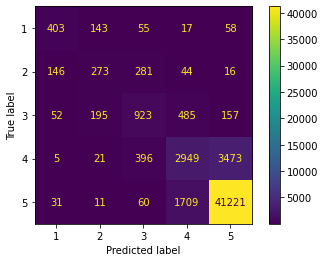

In [44]:
# Display accuracy and confusion matrix of test data
y_true=df_test['rating'].copy().astype('U')
y_pred=df_test['rating_pred'].copy().astype('U')
rf_display = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=['1', '2','3','4','5'])
rf_display.plot()
print(f"GPT-2 accuracy : {accuracy_score(y_true, y_pred):.4f}")

## Results 

After fine-tuning the GPT-2 model and training it to our recipe review data set our accuracy from our final test data was 86.16%! our baseline model accuracy was 81.7%, so we got ourselves an improvement! 

## Future Considerations 
After going through this experiment there is valuable information that could be used in the future for recipe developers, food bloggers, and potentially even food critics. There is plenty of untapped exploratory analysis that one could do with this data set to be able to draw further conclusions on the factors that led to the rating that it did and the ultimate success (or flop) of a recipe. 

